In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
# from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC

import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, word_tokenize
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer

# from sklearn.decomposition import TruncatedSVD

# from imblearn.over_sampling import SMOTE
# from imblearn.pipeline import Pipeline as ImbPipeline
from joblib import dump

# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
df = pd.read_csv('input.csv')

In [3]:
df['label'].value_counts(normalize=True)

label
ntj    0.72151
ytj    0.27849
Name: proportion, dtype: float64

In [4]:
df['label'].value_counts()

label
ntj    32929
ytj    12710
Name: count, dtype: int64

In [5]:
df = df[df['label'] != 'na']

In [6]:
df['label'].value_counts()

label
ntj    32929
ytj    12710
Name: count, dtype: int64

In [7]:
df['label'].value_counts(normalize=True)

label
ntj    0.72151
ytj    0.27849
Name: proportion, dtype: float64

In [8]:
duplicated_all = df[df.duplicated(subset='link_id', keep=False)]
duplicated = df[df.duplicated(subset='link_id', keep='first')]

if not duplicated.empty:
    first_duplicate_id = duplicated['link_id'].iloc[0]
    print(df[df['link_id'] == first_duplicate_id])
else:
    print("No duplicates found excluding the first occurrence.")

No duplicates found excluding the first occurrence.


# NLTK

In [9]:
# Function to map NLTK's part-of-speech tags to wordnet tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return nltk.corpus.wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return nltk.corpus.wordnet.VERB
    elif treebank_tag.startswith('N'):
        return nltk.corpus.wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return nltk.corpus.wordnet.ADV
    else:
        return nltk.corpus.wordnet.NOUN
    
# Initialize the WordNet Lemmatizer
lemmatizer = WordNetLemmatizer()

# Set of English stop words
stop_words = set(stopwords.words('english'))

def nltk_lemmatizer(text):
    words = word_tokenize(text)
    pos_tags = pos_tag(words)
    lemmas = [
        lemmatizer.lemmatize(word, get_wordnet_pos(pos)) 
        for word, pos in pos_tags 
        if word.isalpha() and word.lower() not in stop_words
    ]
    return lemmas


In [10]:
# Encode target variable
def encode_target(y):
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    return y_encoded, le


text_transformer = TfidfVectorizer(tokenizer=nltk_lemmatizer, token_pattern=None)

# Column Transformer
column_transformer = ColumnTransformer([
    ("txt", text_transformer, 'selftext'),
    
], remainder='drop')


# Process data and encode target
X = df.drop(columns=['label'])
y_encoded, label_encoder = encode_target(df['label'])

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

# Preprocess training data: Apply transformations and resampling
X_train_transformed = column_transformer.fit_transform(X_train)
print(f'Shape of data after TF-IDF: {X_train_transformed.shape}')
# X_resampled, y_resampled = SMOTE(random_state=42).fit_resample(X_train_transformed, y_train)
# print(f'Shape of data after SMOTE: {X_resampled.shape}')

# # Apply dimensionality reduction
# svd_transformer = TruncatedSVD(random_state=42, n_components=10000)
# X_reduced = svd_transformer.fit_transform(X_resampled)
# print(f'Shape of data after TruncatedSVD: {X_reduced.shape}')

# Preprocess validation data
X_val_transformed = column_transformer.transform(X_val)
# X_val_reduced = svd_transformer.transform(X_val_transformed)

Shape of data after TF-IDF: (31947, 39679)


In [11]:
# Save the transformers
dump(column_transformer, 'column_transformer.joblib')
# dump(svd_transformer, 'svd_transformer.joblib')
dump(label_encoder, 'label_encoder.joblib')

['label_encoder.joblib']

# Hyper-parameter Tuned Models

## Random Forest

In [12]:
# Define the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
grid_search_rf = GridSearchCV(estimator=RandomForestClassifier(random_state=42),
                              param_grid=param_grid_rf,
                              cv=3,  # Using 5 folds
                              verbose=1,
                              n_jobs=-1)

# Fit GridSearchCV
grid_search_rf.fit(X_train_transformed, y_train)

# Best estimator and parameters
best_rf = grid_search_rf.best_estimator_
best_params_rf = grid_search_rf.best_params_

print("Best parameters for Random Forest:", best_params_rf)
print("Best model:", best_rf)

# Evaluate on the validation set
predictions = best_rf.predict(X_val_transformed)
accuracy = accuracy_score(y_val, predictions)
print("Random Forest Model Accuracy with Hyperparameter Tuning: {:.2f}".format(accuracy))

# Save the best model
dump(best_rf, 'rf_best_model.joblib')

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best model: RandomForestClassifier(random_state=42)
Random Forest Model Accuracy with Hyperparameter Tuning: 0.72


['rf_best_model.joblib']

# Logistic Regression

In [13]:
# Logistic Regression parameter grid
param_grid_lr = {
    'C': [0.01, 0.1, 0.5, 1],  # Broader range might be considered
    'class_weight': ['balanced'],   # Good for handling class imbalance
    'penalty': ['l1', 'l2'],        # L1 for feature selection, L2 for regularization
    'solver': ['liblinear'],        # Compatible with both L1 and L2
    'max_iter': [100, 200, 500, 1000]
}

# Create GridSearchCV object
grid_search_lr = GridSearchCV(estimator=LogisticRegression(random_state=42),
                              param_grid=param_grid_lr,
                              cv=3,  # Using 3 folds
                              verbose=1,
                              n_jobs=-1)

# Fit GridSearchCV
grid_search_lr.fit(X_train_transformed, y_train)

# Best estimator and parameters
best_lr = grid_search_lr.best_estimator_
best_params_lr = grid_search_lr.best_params_

print("Best parameters for Logistic Regression:", best_params_lr)
print("Best model:", best_lr)

# Evaluate on the validation set
predictions = best_lr.predict(X_val_transformed)
accuracy = accuracy_score(y_val, predictions)
print("Logistic Regression Accuracy with Hyperparameter Tuning: {:.2f}".format(accuracy))

# Save the best model
dump(best_lr, 'lr_best_model.joblib')

Fitting 3 folds for each of 32 candidates, totalling 96 fits
Best parameters for Logistic Regression: {'C': 0.01, 'class_weight': 'balanced', 'max_iter': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best model: LogisticRegression(C=0.01, class_weight='balanced', penalty='l1',
                   random_state=42, solver='liblinear')
Logistic Regression Accuracy with Hyperparameter Tuning: 0.72


['lr_best_model.joblib']

# Decision Tree

In [14]:
# Decision Tree parameter grid
param_grid_dt = {
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create GridSearchCV object
grid_search_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                              param_grid=param_grid_dt,
                              cv=3,
                              verbose=1,
                              n_jobs=-1)

# Fit GridSearchCV
grid_search_dt.fit(X_train_transformed, y_train)

# Best estimator and parameters
best_dt = grid_search_dt.best_estimator_
best_params_dt = grid_search_dt.best_params_

print("Best parameters for Decision Tree:", best_params_dt)
print("Best model:", best_dt)

# Evaluate on the validation set
predictions = best_dt.predict(X_val_transformed)
accuracy = accuracy_score(y_val, predictions)
print("Decision Tree Accuracy with Hyperparameter Tuning: {:.2f}".format(accuracy))

# Save the best model
dump(best_dt, 'dt_best_model.joblib')

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best model: DecisionTreeClassifier(max_depth=10, min_samples_leaf=4, random_state=42)
Decision Tree Accuracy with Hyperparameter Tuning: 0.71


['dt_best_model.joblib']

# Support Vector Classifier

In [15]:
# SVC parameter grid
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# Create GridSearchCV object
grid_search_svc = GridSearchCV(estimator=SVC(random_state=42),
                               param_grid=param_grid_svc,
                               cv=3,
                               verbose=1,
                               n_jobs=-1)

# Fit GridSearchCV
grid_search_svc.fit(X_train_transformed, y_train)

# Best estimator and parameters
best_svc = grid_search_svc.best_estimator_
best_params_svc = grid_search_svc.best_params_

print("Best parameters for SVC:", best_params_svc)
print("Best model:", best_svc)

# Evaluate on the validation set
predictions = best_svc.predict(X_val_transformed)
accuracy = accuracy_score(y_val, predictions)
print("SVC Accuracy with Hyperparameter Tuning: {:.2f}".format(accuracy))

# Save the best model
dump(best_svc, 'svc_best_model.joblib')

Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best parameters for SVC: {'C': 1, 'kernel': 'rbf'}
Best model: SVC(C=1, random_state=42)
SVC Accuracy with Hyperparameter Tuning: 0.72


['svc_best_model.joblib']

# XGBoost 

In [16]:
# XGBoost parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Create GridSearchCV object
grid_search_xgb = GridSearchCV(estimator=XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
                               param_grid=param_grid_xgb,
                               cv=3,
                               verbose=1,
                               n_jobs=-1)

# Fit GridSearchCV
grid_search_xgb.fit(X_train_transformed, y_train)

# Best estimator and parameters
best_xgb = grid_search_xgb.best_estimator_
best_params_xgb = grid_search_xgb.best_params_

print("Best parameters for XGBoost:", best_params_xgb)
print("Best model:", best_xgb)

# Evaluate on the validation set
predictions = best_xgb.predict(X_val_transformed)
accuracy = accuracy_score(y_val, predictions)
print("XGBoost Accuracy with Hyperparameter Tuning: {:.2f}".format(accuracy))

# Save the best model
dump(best_xgb, 'xgb_best_model.joblib')

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}
Best model: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)
XGBoost Accuracy with Hyperparameter Tuning: 0.72


['xgb_best_model.joblib']

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Transform the test dataset
X_test_transformed = column_transformer.transform(X_test)
# y_test_transformed = label_encoder.transform(y_test)



Best parameters for Logistic Regression:
{'C': 0.01, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Classification Report for Logistic Regression on Test Dataset:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      4940
           1       0.00      0.00      0.00      1906

    accuracy                           0.72      6846
   macro avg       0.36      0.50      0.42      6846
weighted avg       0.52      0.72      0.60      6846

Classification Report for Logistic Regression on Validation Dataset:


C:\Users\shreenithi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shreenithi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shreenithi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NameError: name 'y_val_transformed' is not defined

Best parameters for RandomForest:
{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}
Classification Report for RandomForest on Test Dataset:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      4940
           1       0.79      0.02      0.03      1906

    accuracy                           0.72      6846
   macro avg       0.76      0.51      0.44      6846
weighted avg       0.74      0.72      0.61      6846

Classification Report for RandomForest on Validation Dataset:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      4939
           1       0.

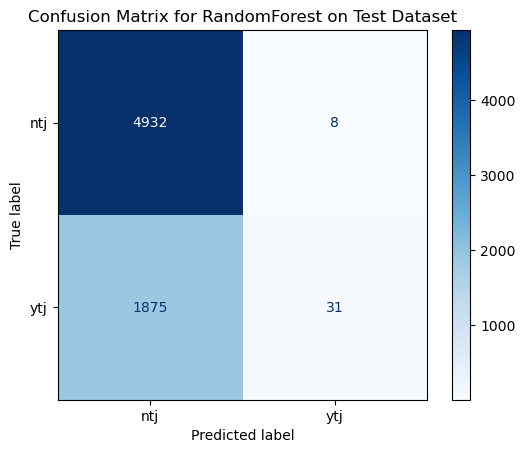

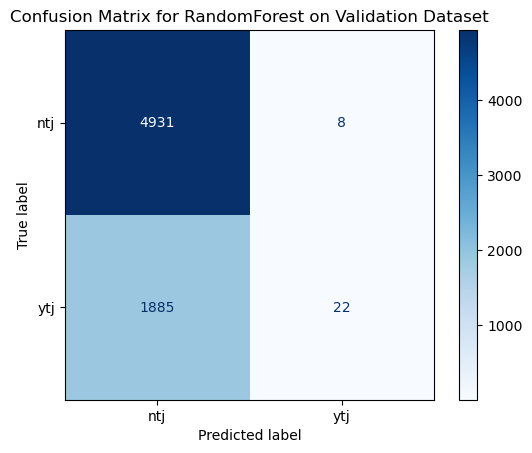



Best parameters for Logistic Regression:
{'C': 0.01, 'class_weight': 'balanced', 'dual': False, 'fit_intercept': True, 'intercept_scaling': 1, 'l1_ratio': None, 'max_iter': 100, 'multi_class': 'auto', 'n_jobs': None, 'penalty': 'l1', 'random_state': 42, 'solver': 'liblinear', 'tol': 0.0001, 'verbose': 0, 'warm_start': False}
Classification Report for Logistic Regression on Test Dataset:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      4940
           1       0.00      0.00      0.00      1906

    accuracy                           0.72      6846
   macro avg       0.36      0.50      0.42      6846
weighted avg       0.52      0.72      0.60      6846

Classification Report for Logistic Regression on Validation Dataset:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      4939
           1       0.00      0.00      0.00      1907

    accuracy                           0.72     

C:\Users\shreenithi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shreenithi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shreenithi\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\shreenithi\anaconda3\Lib\site-p

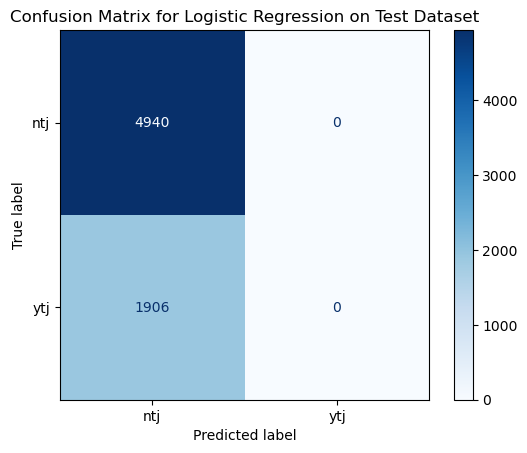

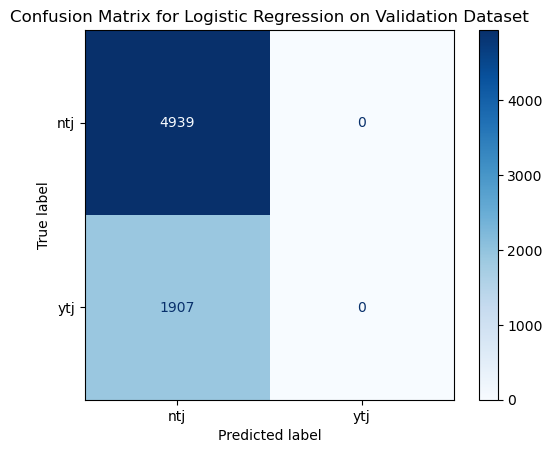



Best parameters for DecisionTree:
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 42, 'splitter': 'best'}
Classification Report for DecisionTree on Test Dataset:
              precision    recall  f1-score   support

           0       0.72      0.97      0.83      4940
           1       0.33      0.04      0.07      1906

    accuracy                           0.71      6846
   macro avg       0.53      0.50      0.45      6846
weighted avg       0.61      0.71      0.62      6846

Classification Report for DecisionTree on Validation Dataset:
              precision    recall  f1-score   support

           0       0.72      0.97      0.83      4939
           1       0.28      0.03      0.06      1907

    accuracy                           0.71      6846
   macro avg       0.50   

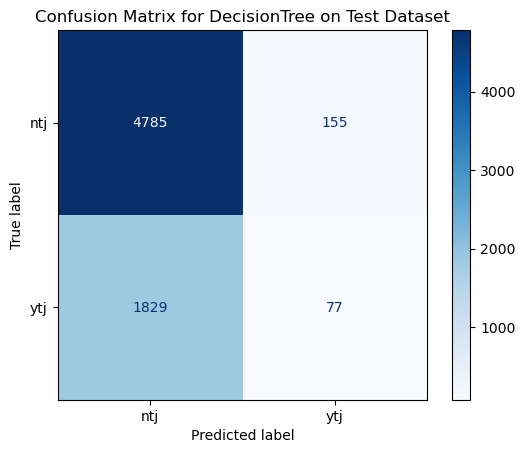

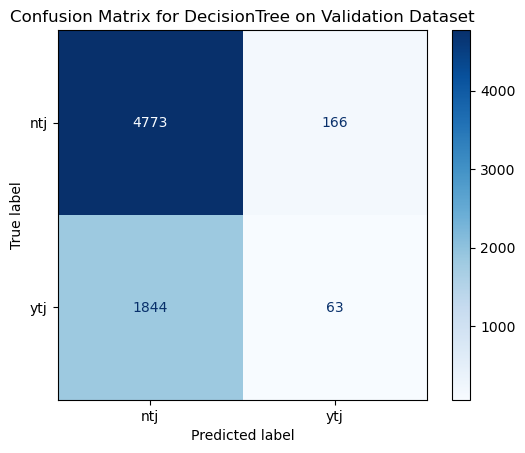



Best parameters for SVC:
{'C': 1, 'break_ties': False, 'cache_size': 200, 'class_weight': None, 'coef0': 0.0, 'decision_function_shape': 'ovr', 'degree': 3, 'gamma': 'scale', 'kernel': 'rbf', 'max_iter': -1, 'probability': False, 'random_state': 42, 'shrinking': True, 'tol': 0.001, 'verbose': False}
Classification Report for SVC on Test Dataset:
              precision    recall  f1-score   support

           0       0.73      1.00      0.84      4940
           1       0.76      0.03      0.06      1906

    accuracy                           0.73      6846
   macro avg       0.75      0.51      0.45      6846
weighted avg       0.74      0.73      0.62      6846

Classification Report for SVC on Validation Dataset:
              precision    recall  f1-score   support

           0       0.72      1.00      0.84      4939
           1       0.66      0.02      0.04      1907

    accuracy                           0.72      6846
   macro avg       0.69      0.51      0.44      684

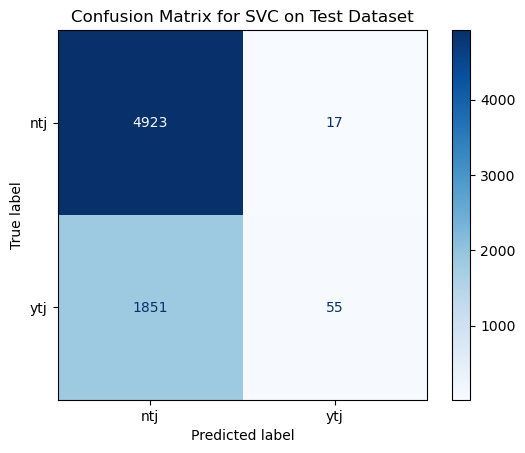

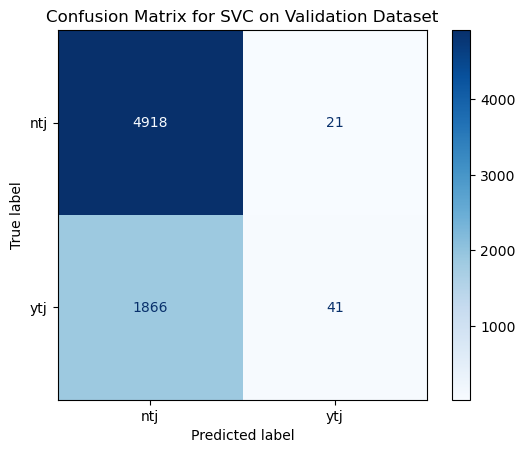



Best parameters for XGBoost:
{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'device': None, 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': 'logloss', 'feature_types': None, 'gamma': None, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.1, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 3, 'max_leaves': None, 'min_child_weight': None, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 100, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': 42, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None, 'use_label_encoder': False}
Classification Report for XGBoost on Test D

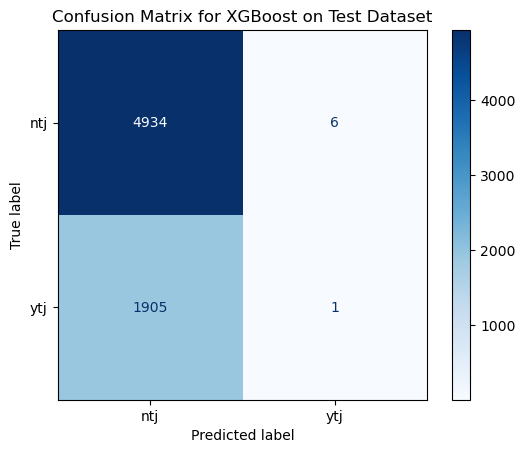

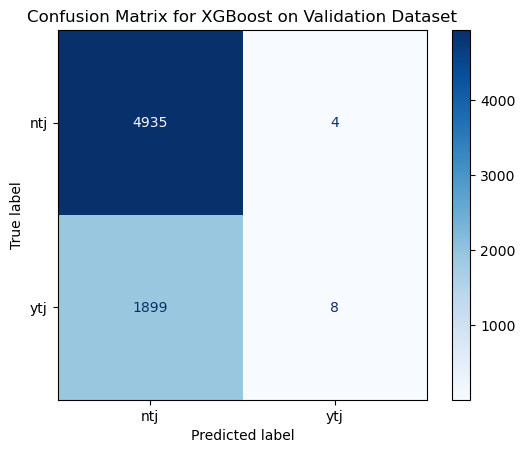

In [29]:
# List of best models and their names
best_models = {
    "RandomForest": best_rf,
    "Logistic Regression": best_lr,
    "DecisionTree": best_dt,
    "SVC": best_svc,
    "XGBoost": best_xgb
}
# Generate reports for each model
for model_name, model in best_models.items():
    print(f"Best parameters for {model_name}:")
    print(model.get_params())
    
    # Predict on the test dataset
    y_test_pred = model.predict(X_test_transformed)
    
    # Predict on the validation dataset
    y_val_pred = model.predict(X_val_transformed)
    
    # Generate classification report for the test dataset
    print(f"Classification Report for {model_name} on Test Dataset:")
    print(classification_report(y_test, y_test_pred))
    
    # Generate classification report for the validation dataset
    print(f"Classification Report for {model_name} on Validation Dataset:")
    print(classification_report(y_val, y_val_pred))
    
    # Plot confusion matrix for the test dataset
    cm_test = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=label_encoder.classes_)
    disp_test.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name} on Test Dataset")
    plt.show()
    
    # Plot confusion matrix for the validation dataset
    cm_val = confusion_matrix(y_val, y_val_pred)
    disp_val = ConfusionMatrixDisplay(confusion_matrix=cm_val, display_labels=label_encoder.classes_)
    disp_val.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {model_name} on Validation Dataset")
    plt.show()
    
    print("\n" + "="*60 + "\n")


In [26]:
import sklearn
print(sklearn.__version__)

1.2.2
